In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
xlsx_path = '/content/drive/MyDrive/Учеба IT/AB-testingGB/Homework9/test_results.xlsx'
data = pd.read_excel(xlsx_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [ ]:
len(data['userid'].unique()) # выборка 90189 юзеров, из них уникальных юзеров 90189, генеральная совокупность порядка 9999861 юзеров.

90189

In [ ]:
data['version'].unique() # играют в две разные версии

array(['gate_30', 'gate_40'], dtype=object)

In [ ]:
data[(data['version'] == 'gate_30')]['sum_gamerounds'].max()
# выборка группы A имеет 1 явный статистический выброс, превышающий матожидание почти в тысячу раз
# избавимся от него с помощью булевой маски
data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 49000)]['sum_gamerounds'].max()
# подобным образом проверяем группу B и не находим в ней таких отклонений

2640

In [5]:
# import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
a_array = data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 49000)]['sum_gamerounds'].values
b_array = data[data['version'] == 'gate_40']['sum_gamerounds'].values

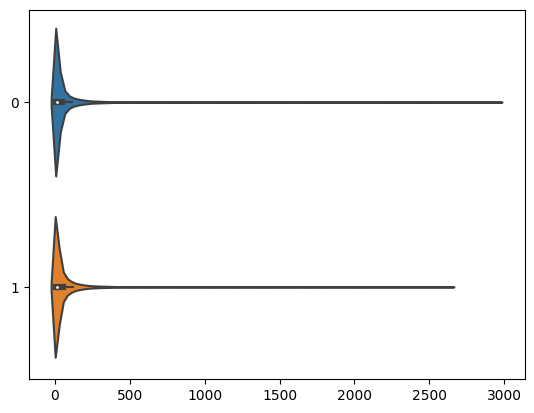

In [7]:
# plt.figure(figsize=(5, 5))
sns.violinplot([a_array, b_array], orient='h');

In [ ]:
import scipy.stats as stats

print(stats.kstest(a_array, 'expon').pvalue)
# stats.kstest(a_array, 'norm')
stats.kstest(b_array, 'expon').pvalue
# stats.kstest(b_array, 'norm')

Нет, не экспоненциальное и не нормальное.

In [9]:
# data['sum_gamerounds'].groupby(data['version']).describe()
# data['retention_1'].groupby(data['version']).value_counts()
data['retention_7'].groupby(data['version']).value_counts()

version  retention_7
gate_30  0              36198
         1               8502
gate_40  0              37210
         1               8279
Name: retention_7, dtype: int64

Группа А (gate_30):

1. size=44700
2. метрика "Cыграно раундов всего": min=0, max=49854, std=256.7, mean=52.45
3. метрика "Удержание 1 дня": min=0, max=1, std=0.4973, mean=0.4481 (доля 20034/44700)
4. метрика "Удержание 7 дня": min=0, max=1, std=0.3924, mean=0.1902 (доля 8502/44700)

Группа B (gate_40):

1. size=45489
2. метрика "Cыграно раундов всего": min=0, max=2640, std=103.3, mean=51.3
3. метрика "Удержание 1 дня": min=0, max=1, std=0.4966, mean=0.4423 (доля 20119/45489)
4. метрика "Удержание 7 дня": min=0, max=1, std=0.3858, mean=0.182 (доля 8279/45489)

https://www.evanmiller.org/ab-testing/chi-squared.html

Для alpha=0.05 статистически значимой разницы между группами в метрике "Удержание 1 дня" нет (p=0.074), а для метрики "Удержание 7 дня" выявлено статистически значимое ухудшение (p=0.00155).

https://www.evanmiller.org/ab-testing/t-test.html

Для alpha=0.05 статистически значимой разницы между группами в метрике "Cыграно раундов всего" нет (p=0.38).


In [19]:
a_array = data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 49000)]['sum_gamerounds'].values
b_array = data[data['version'] == 'gate_40']['sum_gamerounds'].values

stats.ttest_ind(a_array, b_array)
# по количеству сыгранных раундов статистически значимой разницы в тестируемых группах не выявлено и с помощью пакета для статанализа Python

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

In [20]:
a_ret1_frac = data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 49000)]['retention_1']
b_ret1_frac = data[data['version'] == 'gate_40']['retention_1']

stats.ttest_ind(b_ret1_frac, a_ret1_frac)
# по удержанию 1 дня статистически значимой разницы в тестируемых группах также не выявлено

Ttest_indResult(statistic=-1.787115337299244, pvalue=0.07392220630182521)

In [23]:
a_ret7_frac = data[(data['version'] == 'gate_30') & (data['sum_gamerounds'] < 49000)]['retention_7']
b_ret7_frac = data[data['version'] == 'gate_40']['retention_7']

stats.ttest_ind(a_ret7_frac, b_ret7_frac)
# подтверждаем, что ухудшение метрики (mean_A > mean_B), наблюдаемое в группе B, статистически значимо (p-value = 0.0016, что меньше 0.05)

Ttest_indResult(statistic=3.1575495965685936, pvalue=0.0015915357297854773)

На основании результатов статанализа A/B-теста необходимо дать менеджеру проекта следующую рекомендацию: нововведение распространять на весь продукт не надо, откатить до предыдущей версии там, где оно было внедрено.